In [34]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from datetime import datetime
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

%matplotlib inline

In [35]:
main_start = datetime.now()
raw_data = pd.read_csv('epi_r.csv')

In [36]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [37]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

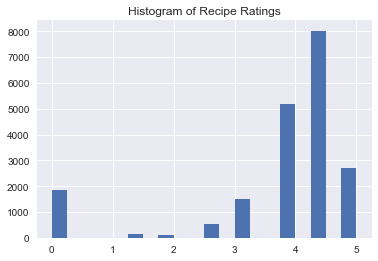

In [38]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [39]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [40]:
# Turn the rating into a classification between good rating and bad rating with the threshold set to 3.5 for a good rating.
threshold = 3.75
raw_data['good rating'] = np.where(raw_data['rating'] >= threshold, 1,0)

# Let's drop the nulls to incorporate more possible features
base_data = raw_data.dropna()
base_data.rating.describe()

count    15864.000000
mean         3.760952
std          1.285518
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

In [41]:
# Let's look a the balance of values
print(base_data['good rating'].value_counts())

1    12794
0     3070
Name: good rating, dtype: int64


In [42]:
# Let's rebalance the data by first extracting all of the positive ratings from bad ratings
good = base_data[base_data['good rating'] == 1]
bad = base_data[base_data['good rating'] == 0]

# Take a random sample from the good ones
msk = np.random.rand(len(good)) < 0.4
train_data = good[msk]

# Join the good data back with the bad ratings
train_data = train_data.append(bad)
print(train_data['good rating'].value_counts())

1    5102
0    3070
Name: good rating, dtype: int64


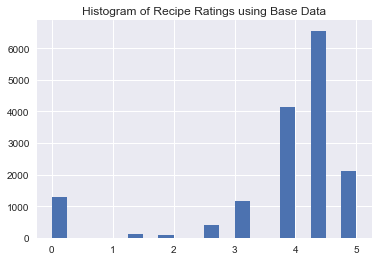

In [43]:
base_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings using Base Data')
plt.show()

In [44]:
# Let's try PCA to get our number of features down to 30.
start = datetime.now()
svc = SVC()
X = base_data.drop(['title', 'rating', 'good rating'], 1)
Y = base_data['good rating']
pca = PCA(n_components=30)
X_std_pca = pca.fit_transform(X)
X1 = pd.DataFrame(X_std_pca)
fit = svc.fit(X1, Y)
print('SVC score utilizing PCA generated features: {}'.format(svc.score(X1, Y)))
print(cross_val_score(svc, X1, Y, cv=5))
print('It took the following time to complete this task:', datetime.now() - start)

SVC score utilizing PCA generated features: 0.9592788703983863
[ 0.82823826  0.82382603  0.82351087  0.82697762  0.82944515]
It took the following time to complete this task: 0:02:33.488687


In [45]:
# Let's use RFE/Lasso to try to narrow down our features to 30.
start = datetime.now()
lr = LogisticRegression(C=1, penalty='l1')
X = base_data.drop(['title', 'rating', 'good rating'], 1)
Y = base_data['good rating']
rfe = RFE(lr,n_features_to_select=30) 
fit = rfe.fit(X,Y)
result_RFE = pd.DataFrame(list(zip(X.head(0), rfe.ranking_, rfe.support_)),
                          columns=['Features','Ranking','Support'] ) 
print(result_RFE.sort_values('Ranking'))
print('It took the following time to complete this task:', datetime.now() - start)

                 Features  Ranking  Support
597     stuffing/dressing        1     True
487              pork rib        1     True
46        beef tenderloin        1     True
224            frangelico        1     True
488       pork tenderloin        1     True
147             condiment        1     True
285             ice cream        1     True
228         friendsgiving        1     True
438               pancake        1     True
239                   gin        1     True
313                  kiwi        1     True
655            weelicious        1     True
417               oatmeal        1     True
320             lamb chop        1     True
241           goat cheese        1     True
190                 drink        1     True
469               pickles        1     True
351        lunar new year        1     True
408   no meat, no problem        1     True
675                 snack        1     True
674             leftovers        1     True
6         22-minute meals       

In [46]:
# Let's try SVC using the features we picked up from RFE
start = datetime.now()
svc = SVC()
X = base_data[['stuffing/dressing', 'pork rib', 'beef tenderloin', 'frangelico', 'condiment', 'ice cream', 'friendsgiving',
             'pancake', 'gin', 'kiwi','weelicious', 'oatmeal', 'lamb chop', 'goat cheese', 'drink', 'pickles', 'lunar new year',
             'no meat, no problem','snack', 'leftovers', '22-minute meals', '3-ingredient recipes', 'harpercollins', 'créme de cacao',
             'low sugar', 'tangerine', 'vermouth', 'low carb', 'mandoline']]
Y = base_data['good rating']
svc.fit(X,Y)
print('SVC score with the features selected using lasso regression and RFE: {}'.format(svc.score(X, Y)))
print(cross_val_score(svc, X, Y, cv=5))
print('It took the following time to complete this task:', datetime.now() - start)

SVC score with the features selected using lasso regression and RFE: 0.8125945537065052
[ 0.81058935  0.81216514  0.81090451  0.81279546  0.81147541]
It took the following time to complete this task: 0:00:26.889995


In [47]:
# Let's use Random Forest to select features down to 30.
start = datetime.now()
X = base_data.drop(['title', 'rating', 'good rating'], 1)
Y = base_data['good rating']
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
df2 = X.columns.get_values()
feat_labels = df2.tolist()

# Train the classifier
clf.fit(X, Y)
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.15
for feature in zip(X, clf.feature_importances_):
    print(feature)

print('It took the following time to complete this task:', datetime.now() - start)

('calories', 0.060017174994648308)
('protein', 0.04572753016427572)
('fat', 0.048365297662186106)
('sodium', 0.059313920578191522)
('#cakeweek', 6.3543159228153176e-05)
('#wasteless', 2.5702881089236346e-06)
('22-minute meals', 3.6085035153861753e-05)
('3-ingredient recipes', 0.0013714285309988628)
('30 days of groceries', 4.8862390781574676e-05)
('advance prep required', 0.0014461969235383665)
('alabama', 4.1450068889388273e-06)
('alaska', 1.8716805004262287e-06)
('alcoholic', 0.0050355810957737066)
('almond', 0.0025353189622558652)
('amaretto', 0.00035628695039350834)
('anchovy', 0.00057495195454272425)
('anise', 0.0013524067610482375)
('anniversary', 0.00040916260851601278)
('anthony bourdain', 0.00011807338207972167)
('aperitif', 0.00013778369420937607)
('appetizer', 0.0039159201985181028)
('apple', 0.0027575122662863516)
('apple juice', 0.00011311181232417737)
('apricot', 0.0014375524606021314)
('arizona', 8.7373442317581947e-06)
('artichoke', 0.0012123196130045635)
('arugula', 0.

In [48]:
start = datetime.now()
sfm = SelectFromModel(clf, threshold=0.005)
number_of_features =[]
# Train the selector
sfm.fit(X, Y)
for feature_list_index in sfm.get_support(indices=True):
    number_of_features.append(feat_labels[feature_list_index])
    print(feat_labels[feature_list_index])
    
print('Number of features in this list: {}'.format(len(number_of_features)))
print('It took the following time to complete this task:', datetime.now() - start)

calories
protein
fat
sodium
alcoholic
bake
bon appétit
dairy
drink
egg
fall
fruit
gourmet
herb
house & garden
kid-friendly
kosher
milk/cream
onion
peanut free
quick & easy
side
soy free
spring
summer
tomato
tree nut free
vegan
vegetable
vegetarian
wheat/gluten-free
winter
Number of features in this list: 32
It took the following time to complete this task: 0:00:37.641288


In [49]:
# Let's try SVC using the features we picked up from Random Forest
start = datetime.now()
svc = SVC()
X = base_data[['calories', 'protein', 'fat', 'sodium', 'alcoholic', 'bake', 'bon appétit', 'dairy', 'drink', 'egg', 'fall', 
               'fruit', 'gourmet', 'herb', 'house & garden', 'kid-friendly', 'kosher', 'milk/cream', 'onion', 'peanut free', 
               'quick & easy', 'side', 'soy free', 'spring', 'summer', 'tomato', 'tree nut free', 'vegan', 'vegetable',
               'vegetarian']]
Y = base_data['good rating']
svc.fit(X,Y)
print('SVC score utilizing the random forest generated features: {}'.format(svc.score(X, Y)))
print(cross_val_score(svc, X, Y, cv=5))
print('It took the following time to complete this task:', datetime.now() - start)

SVC score utilizing the random forest generated features: 0.9565052950075643
[ 0.82760794  0.82382603  0.8225654   0.82855342  0.82629256]
It took the following time to complete this task: 0:02:35.378079


In [50]:
print('The run time for this notebook is:', datetime.now() - main_start)

The run time for this notebook is: 0:18:36.218887


In this challenge, I used three different feature selection methods to see which one worked best with SVC. RFE utilizing Lasso Regression to pick the best features worked the best with a score near 0.81.